In [1]:
# if jupyterlab:
%matplotlib widget
# if jupyter notebook:
# %matplotlib notebook

import numpy as np 
from recoMRD import recoMRD
from recoMRD import utils
from bart import bart

In [2]:
filename = './../example_data/meas_MID00024_FID04971_localizer3D_iPAT2.mrd'
mrd = recoMRD(filename)

kspace_osremoved = mrd.remove_oversampling(mrd.kspace['image_scan'], is_kspace=True)
img_sos = mrd.coil_combination(kspace_osremoved, method='sos')

MRD file has more than one group. The last group will be imported.
Number of reference scans: 432
Number of image     scans: 1998
k-space size in protocol: 448 x 224 x 18
image   size in protocol: 224 x 224 x 18
k-space encoding size (224 x 18) differs from max encoding step (223 x 18)
This can be due to parallel imaging, partial Fourier, etc.
Acceleration factor: 2 x 1
Reference scan type: integrated
Existing scans: acs, noise, image_scan.
Fully sampled array size=[16, 448, 224, 18, 1, 1, 1, 1, 1, 1, 1]


Filling acs       , size=[16, 448, 24, 18, 1, 1, 1, 1, 1, 1, 1]: 100%|██████████| 432/432 [00:00<00:00, 7987.35it/s]
Filling noise     , size=[16, 448, 1, 1, 1, 1, 1, 1, 1, 1, 1]: 100%|██████████| 1/1 [00:00<00:00, 1851.79it/s]
Filling image_scan, size=[16, 448, 111, 18, 1, 1, 1, 1, 1, 1, 1]: 100%|██████████| 1998/1998 [00:00<00:00, 7691.99it/s]


Remove oversampling... Done.


Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 30.51it/s]


/kyb/agks/aaghaeifar/.local/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


(224, 224, 18)


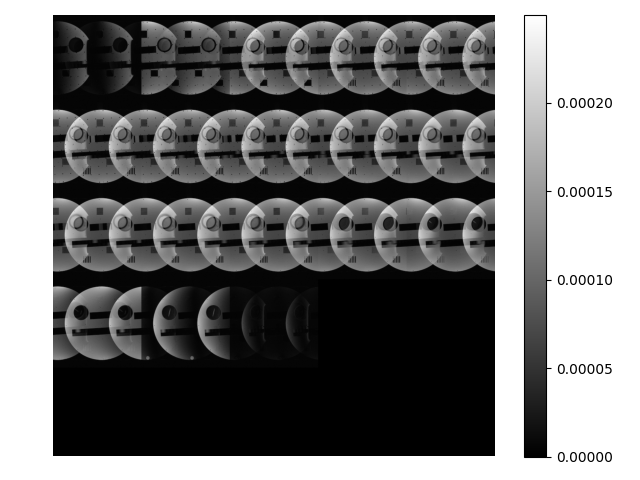

In [3]:
# sum of square reco
print(img_sos.squeeze().shape)
temp = img_sos.squeeze()
temp = utils.plot_mosaic(temp, cmap='gray')

(448, 224, 18)
Acceleration Factor: R=2.02


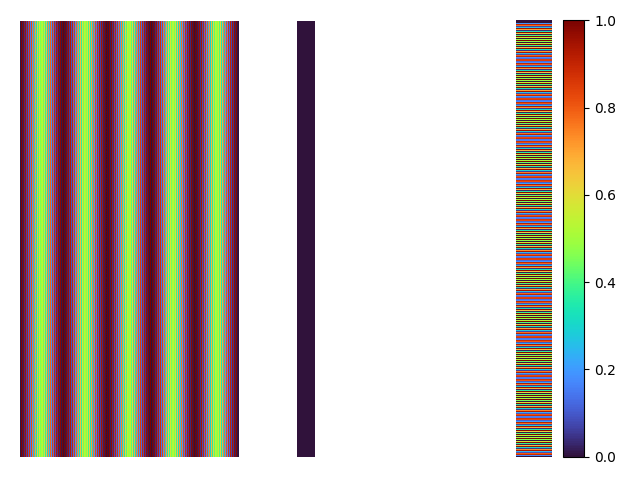

In [4]:
# show sampling pattern
temp = mrd.kspace['image_scan'].squeeze()[0,...] # take the first coil
mask = bart.bart(1, 'pattern', temp).real > 0
print(mask.shape)
shp = [x // 2 for x in mask.shape]
R = np.prod(np.shape(mask)) / np.sum(mask) # acceleration factor
utils.plot3D(mask, clim=[0, 1])
print('Acceleration Factor: R={:.2f}'.format(R))

(16, 448, 224, 18)
(448, 3584)


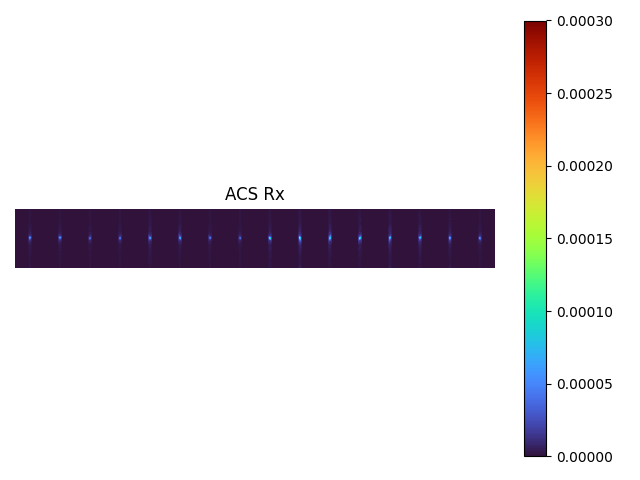

In [5]:
# show some Rx channels from reference scan
temp = mrd.kspace['acs'].squeeze()
print(temp.shape)
temp = np.abs(np.moveaxis(temp[:,:,:,1],0,-1))
temp = utils.plot_mosaic(temp, grid_shape = [1, temp.shape[2]], clim=[0, 3e-4], title='ACS Rx')
print(temp.shape)

Remove oversampling... Done.


Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 26.39it/s]


(1, 224, 224, 18, 1, 1, 1, 1, 1, 1, 1)
(224, 224, 18)


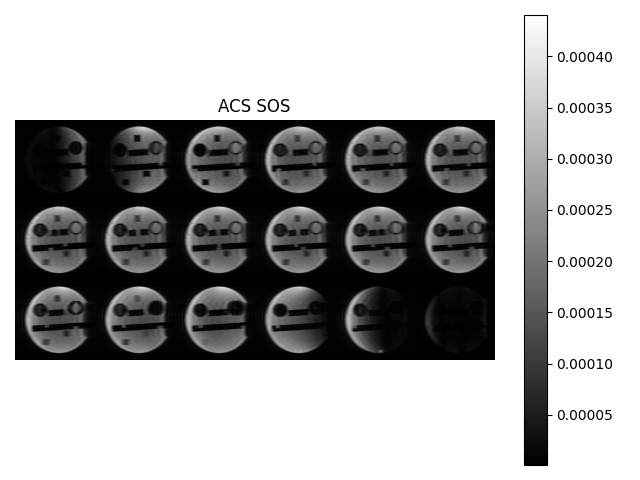

In [6]:
# sum of square of reference scan
acs = mrd.remove_oversampling(mrd.kspace['acs'], is_kspace=True)
acs_img = mrd.coil_combination(acs, method='sos')

temp = acs_img.squeeze()
print(acs_img.shape)
print(temp.shape)
temp = utils.plot_mosaic(temp, grid_shape = [3, temp.shape[2]//3], cmap='gray', title='ACS SOS')


In [7]:
%%time
# calculate coil sensitivity, using espirit method
coils_sensitivity_espirit = mrd.calc_coil_sensitivity(acs, method='espirit')
print(coils_sensitivity_espirit.shape)

Done.
(16, 224, 224, 18, 1)
CPU times: user 153 ms, sys: 138 ms, total: 292 ms
Wall time: 1min 29s


In [8]:
%%time
# use caldir method to get coil sensitivity 
coils_sensitivity_caldir = mrd.calc_coil_sensitivity(acs, method='caldir')
print(coils_sensitivity_caldir.shape)

Calibration region 112x24x18
Done.
(16, 224, 224, 18, 1)
CPU times: user 129 ms, sys: 174 ms, total: 303 ms
Wall time: 3.11 s


In [9]:
%%time
# using walsh method to get coil sensitivity
coils_sensitivity_walsh = mrd.calc_coil_sensitivity(acs, method='walsh')
print(coils_sensitivity_walsh.shape)

Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 29.22it/s]


(16, 224, 224, 18, 1)
CPU times: user 42.6 s, sys: 318 ms, total: 42.9 s
Wall time: 3.11 s


(48, 224, 224)
(224, 224, 48)


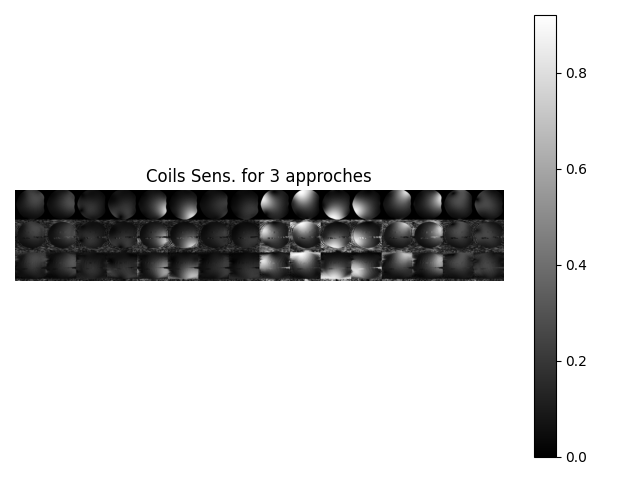

In [10]:
temp = np.concatenate((coils_sensitivity_espirit, coils_sensitivity_caldir, coils_sensitivity_walsh), axis = 0)
temp = temp.squeeze()[...,9]
print(temp.shape)
temp = np.abs(np.moveaxis(temp,0,-1))
print(temp.shape)
temp = utils.plot_mosaic(temp, grid_shape = [3, temp.shape[2]/3], cmap='gray', title='Coils Sens. for 3 approches')


In [13]:
img = mrd.remove_oversampling(mrd.kspace['image_scan'], is_kspace=True)
print(img.shape)
volume_comb_espirit = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_espirit)
volume_comb_caldir = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_caldir)
volume_comb_walsh = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_walsh)

print(volume_comb_espirit.shape)



Remove oversampling... Done.
(16, 224, 224, 18, 1, 1, 1, 1, 1, 1, 1)


Fourier transform:   0%|          | 0/16 [00:00<?, ?it/s]

Fourier transform: 100%|██████████| 16/16 [00:00<00:00, 27.85it/s]


Size: 903168 Samples: 447552 Acc: 2.02
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 4.065128
(1, 224, 224, 18, 1, 1, 1, 1, 1, 1, 1)


(224, 224, 18, 3)
(224, 224, 4, 3)
(224, 224, 12)


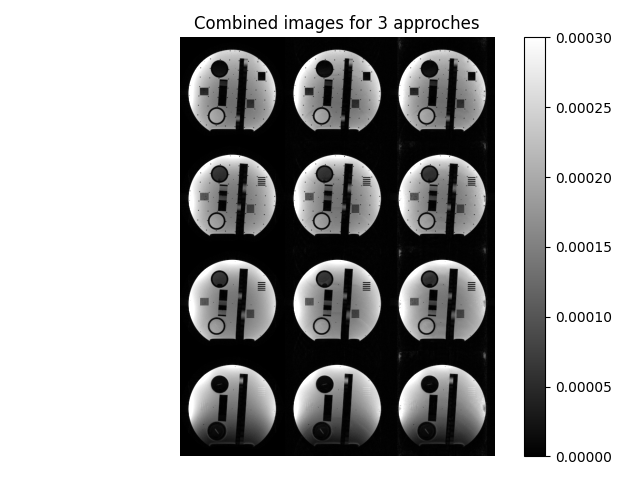

In [12]:
temp = np.concatenate((volume_comb_espirit, volume_comb_caldir, volume_comb_walsh), axis = 4).squeeze()
temp = np.abs(temp)
print(temp.shape)
temp = temp[:,:,np.linspace(2,temp.shape[2]-3,4).astype(np.int32),:]
print(temp.shape)
temp = temp.reshape(temp.shape[:2] + (-1,), order='F')
print(temp.shape)
temp = utils.plot_mosaic(temp, grid_shape = [3, temp.shape[2]//3], cmap='gray', clim = [0, 3e-4], transpose = True, title='Combined images for 3 approches')